In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
sns.set()

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', encoding = "ISO-8859-1", header=0,\
                       dtype={'name': 'str',\
                              'department': 'category',\
                              'title': 'category',\
                              'year': 'category',\
                              'dept_clean': 'category',\
                              'title_clean': 'category'})
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 16 columns):
Unnamed: 0     152544 non-null int64
name           152544 non-null object
department     152544 non-null category
title          152544 non-null category
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zipcode        152544 non-null object
year           152544 non-null category
dept_clean     152544 non-null category
title_clean    152544 non-null category
dtypes: category(5), float64(8), int64(1), object(2)
memory usage: 14.2+ MB


0    1.297467e+09
1    1.315063e+09
2    1.384350e+09
3    1.487853e+09
4    1.551892e+09
5    1.580210e+09
6    1.590906e+09
Name: total, dtype: float64


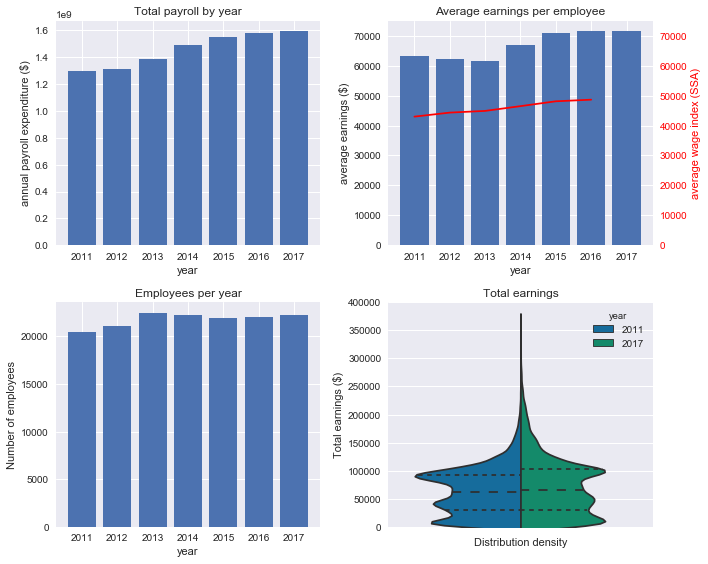

In [3]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['total', 'name']]\
                        .agg({'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
awi = [42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15] # AWI, years 2011-2016

x = total_payroll['year']
y1 = total_payroll['total']
y2 = total_payroll['epc']
y3 = total_payroll['name']
y4 = earnings[['regular', 'total', 'year']].loc[(earnings['year'] == '2011') | (earnings['year'] == '2017')]
y4['all'] = ''
y4['year'] = y4['year'].astype('str')  # bug in pandas or Seaborn? Will not work with categorical data.
print(y1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

ax1.bar(x, y1)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure ($)')
ax1.set_title('Total payroll by year')

ax2.bar(x, y2)
ax2.set_xlabel('year')
ax2.set_ylabel('average earnings ($)')
ax2.set_title('Average earnings per employee')
ax2.set_ylim(0, 75000)

ax2b = ax2.twinx()
ax2b.plot(awi, color='r')
ax2b.set_ylabel('average wage index (SSA)', color='r')
ax2b.tick_params('y', colors='r')
ax2b.set_ylim(0, 75000)
ax2b.set_xlabel('')
# plt.axis('off')
# plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='on', labelbottom='off')
ax2b.axes.grid(False)

ax3.bar(x, y3)
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

sns.violinplot(x='all', y='total', data=y4, hue='year', split=True, inner='quartile', \
               palette='colorblind', orient='v', ax=ax4)
ax4.set_xlabel('Distribution density')
ax4.set_ylabel('Total earnings ($)')
ax4.set_title('Total earnings')
ax4.set_ylim(0, 400000)

plt.tight_layout()
plt.show()

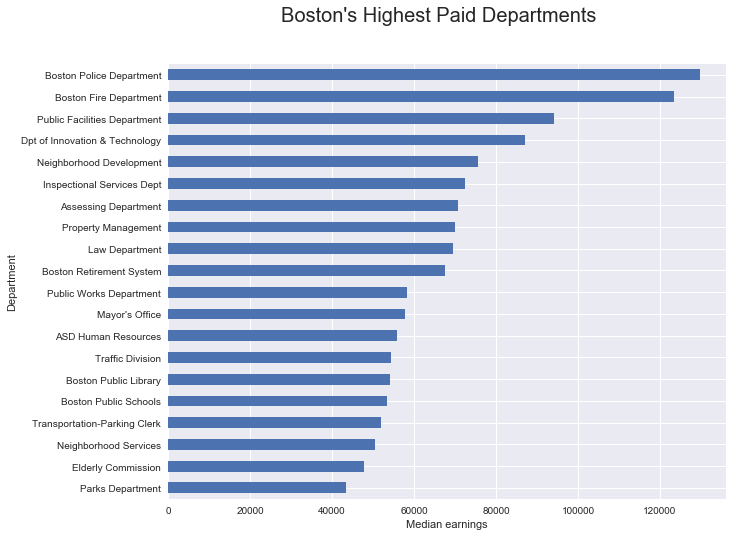

In [4]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.

fig = plt.figure(figsize=(10, 8))                 

large_depts = earnings[earnings.year == '2017'] \
                    .groupby('dept_clean')[['dept_clean', 'total']] \
                    .filter(lambda x: (x['dept_clean'].agg('count') > 50)) \
                    .reset_index() \
                    .groupby('dept_clean')['total'] \
                    .agg(np.median) \
                    .nlargest(20) \
                    .plot \
                    .barh() \
                    .invert_yaxis()

fig.suptitle('Boston\'s Highest Paid Departments', fontsize=20)
_ = plt.ylabel('Department')
_ = plt.xlabel('Median earnings')
# _ = plt.rc('ytick', labelsize=20)
# _ = plt.rc('axes', labelsize=15)

plt.show()

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

68 % of city employees live in Boston (2017).


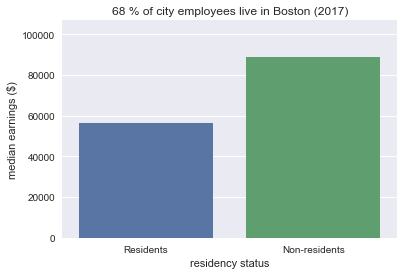

In [5]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2017'))]
outzips = earnings.loc[(~earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2017'))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2017).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
plt.title('%s %% of city employees live in Boston (2017)'%(int(residents)))
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()